# Mixscape reproduction

This vignette reproduces the Mixscape https://satijalab.org/seurat/articles/mixscape_vignette.html Vignette.
We demonstrate that pertpy can reproduce the results and go beyond Mixscape.

In [1]:
import pertpy as pt
import muon as mu
import pandas as pd
import scanpy as sc

Installed version 0.2.0 of pertpy is newer than the latest release 0.1.0! You are running a 
nightly version and features may break!

# Getting the dataset

In [2]:
mdata = pt.dt.papalexi_2021()

In [3]:
mdata

MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

# Preprocessing

## RNA

In [4]:
mdata["rna"]

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [5]:
sc.pp.normalize_total(mdata['rna'])

In [6]:
sc.pp.log1p(mdata['rna'])

In [7]:
sc.pp.highly_variable_genes(mdata['rna'], subset=True)

## Protein

In [8]:
mdata["adt"]

AnnData object with n_obs × n_vars = 20729 × 4
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [9]:
mu.prot.pp.clr(mdata["adt"])

# RNA-based clustering is driven by confounding sources of variation

In [10]:
sc.pp.pca(mdata["rna"])

In [11]:
sc.pp.neighbors(mdata['rna'], metric='cosine')

In [12]:
sc.tl.umap(mdata["rna"])

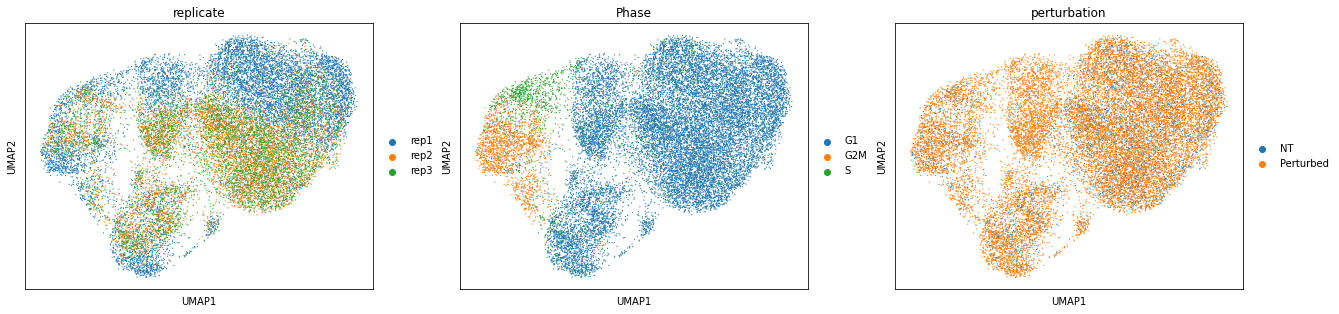

In [13]:
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

# Calculating local perturbation signatures mitigates confounding effects

In [14]:
pt.tl.pert_sign(mdata['rna'], 'perturbation', 'NT', 'replicate')

In [15]:
adata_pert = mdata['rna'].copy()

In [16]:
adata_pert.X = adata_pert.layers['X_pert']

In [17]:
sc.pp.pca(adata_pert)

In [18]:
sc.pp.neighbors(adata_pert, metric='cosine')

In [19]:
sc.tl.umap(adata_pert)

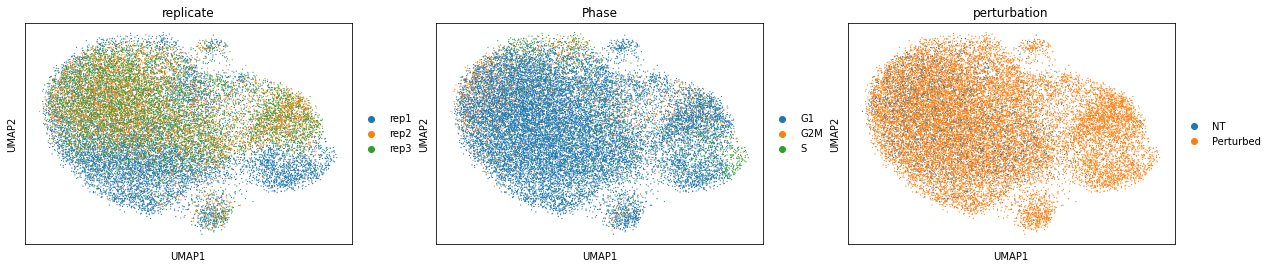

In [20]:
sc.pl.umap(adata_pert, color=['replicate', 'Phase', 'perturbation'])

# Mixscape identifies cells with no detectable perturbation

In [21]:
pt.tl.mixscape(adata = mdata['rna'], control = 'NT', labels='gene_target', layer='X_pert')

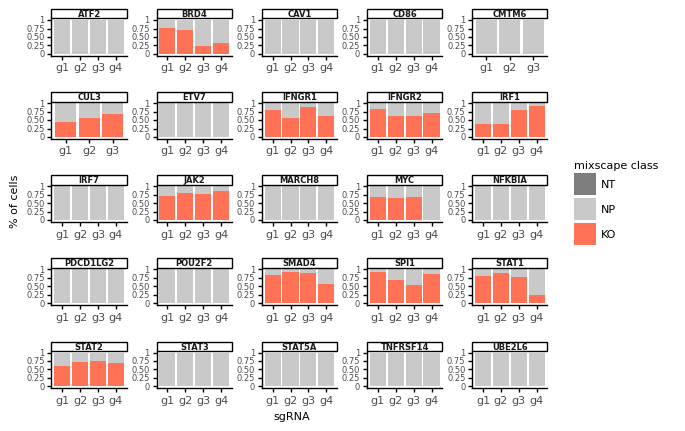

<ggplot: (335158959)>

In [23]:
pt.pl.mixscape_barplot(mdata['rna'])

# Inspecting mixscape results

Explore the perturbation scores of cells.

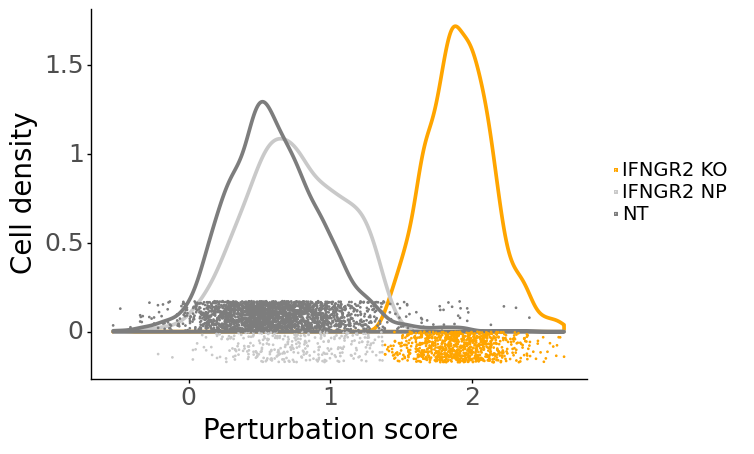

<ggplot: (334180684)>

In [24]:
pt.pl.plotperturbscore(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', color = 'orange')

Inspect the posterior probability values in NP and KO cells.

Trying to set attribute `.obs` of view, copying.
... storing 'mixscape_class' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'mixscape_class_global' as categorical


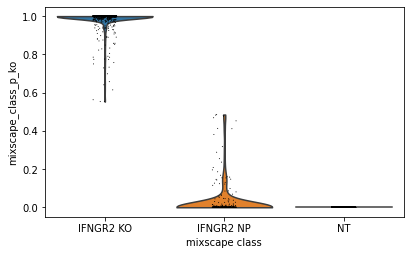

In [25]:
pt.pl.mixscape_violin(adata = mdata['rna'], target_gene_idents=['NT', 'IFNGR2 NP', 'IFNGR2 KO'], groupby='mixscape_class')

Run DE analysis and visualize results on a heatmap ordering cells by their posterior probability values.

... storing 'mixscape_class' as categorical
... storing 'mixscape_class_global' as categorical


categories: IFNGR2 KO, IFNGR2 NP, NT
var_group_labels: NT


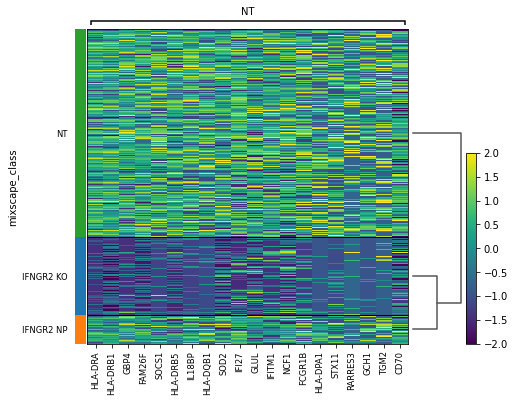

In [26]:
pt.pl.mixscape_heatmap(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', layer='X_pert', control='NT')

Show that only IFNG pathway KO cells have a reduction in PD-L1 protein expression.

Trying to set attribute `.obs` of view, copying.
... storing 'mixscape_class_global' as categorical


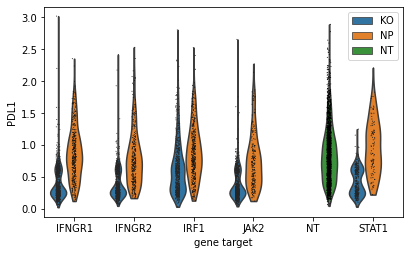

In [27]:
mdata['adt'].obs['mixscape_class_global'] = mdata['rna'].obs['mixscape_class_global']
pt.pl.mixscape_violin(adata = mdata['adt'], target_gene_idents=["NT","JAK2","STAT1","IFNGR1","IFNGR2", "IRF1"], keys='PDL1', groupby='gene_target', hue='mixscape_class_global')

# Visualizing perturbation responses with Linear Discriminant Analysis (LDA)